In [ ]:
import os
import random
import pandas as pd
import numpy
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.tree import export_text
from joblib import dump, load

# Data Generation

In [ ]:
columns = ['Invested Amount', 'Successful Attacks', 'Failed Attacks', 'Business Value', 'Number of Employees', 'Employee Training', 'Known Vulnerabilities', 'External Advisor', 'Risk']
features = columns[:-1]
LEVELS = ["LOW", "MEDIUM", "HIGH"]
prediction_result_mapping = {0: "LOW", 1: "MEDIUM", 2: "HIGH"}

In [ ]:
def generate_data(nr_entries = 1000, min_empl = 30, max_empl = 90000, min_nr_attacks = 0, nr_attacks = 50, 
                  avg_business_value = 5000000, std_business_value = 50000, max_invested_perc = 0.3, max_nr_vulnerabilities = 10):
    df = pd.DataFrame(columns=columns)
    for i in range(0, nr_entries):
        nr_employees = random.randint(min_empl, max_empl)
        employees_training = random.choice(LEVELS)
        failed_attack = random.randrange(nr_attacks)
        succ_attack = random.randrange(nr_attacks)
        business_value = int(numpy.random.normal(loc=avg_business_value, scale=std_business_value))
        invested_perc = random.uniform(0, max_invested_perc)
        invested_amount = int(invested_perc * business_value)
        known_vulnerabilities = random.randrange(max_nr_vulnerabilities)
        external_adv = "NO" if (i % 2) == 0 else "YES"

        # Risk is computed based on the other parameters and is then categorized using 'get_categorized_risk'
        computed_risk = invested_perc - (succ_attack / nr_attacks) + (nr_employees / max_empl) * LEVELS.index(employees_training) - (known_vulnerabilities / max_nr_vulnerabilities) + (i % 2) / 3
        
        df.loc[i] = [invested_amount, succ_attack, failed_attack, business_value, nr_employees, employees_training, known_vulnerabilities, external_adv, get_categorized_risk(computed_risk)]
    return df

def get_categorized_risk(weighted_risk, low_medium_boundary = 1.0, medium_high_boundary = 0.0):
  if weighted_risk >= low_medium_boundary:
      return "LOW"
  elif weighted_risk >= medium_high_boundary and weighted_risk < low_medium_boundary:
      return "MEDIUM"
  else:
      return "HIGH"

In [ ]:
data = generate_data(nr_entries=10000)

In [ ]:
data.head()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor,Risk
0,930168,18,17,5072439,77791,MEDIUM,8,NO,HIGH
1,1211778,10,35,5014920,72635,LOW,7,YES,HIGH
2,112645,47,7,4990529,42769,MEDIUM,7,NO,HIGH
3,544943,17,14,4970089,30229,HIGH,0,YES,MEDIUM
4,364860,17,4,4944402,27235,LOW,6,NO,HIGH


In [ ]:
data.describe()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor,Risk
count,10000,10000,10000,10000,10000,10000,10000,10000,10000
unique,9969,50,50,9712,9452,3,10,2,3
top,448235,3,7,5023316,59,LOW,1,NO,HIGH
freq,2,218,228,3,3,3389,1045,5000,6044


## Data Export as .csv

In [ ]:
# data.to_csv('data.csv')

# Data Processing

## Categorization Step

In [ ]:
levels_mapping = { 'LOW': 0, 'MEDIUM': 1, 'HIGH': 2 }
advisor_mapping = { 'NO': 0, 'YES': 1 }

data = data.replace({'Employee Training': levels_mapping, 'Risk': levels_mapping, 'External Advisor': advisor_mapping})

In [ ]:
data.head()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor,Risk
0,930168,18,17,5072439,77791,1,8,0,2
1,1211778,10,35,5014920,72635,0,7,1,2
2,112645,47,7,4990529,42769,1,7,0,2
3,544943,17,14,4970089,30229,2,0,1,1
4,364860,17,4,4944402,27235,0,6,0,2


## Normalization Step

In [ ]:
normalized_data = data[features].apply(lambda x: ( (x - x.min()) / (x.max() - x.min())))
normalized_data.head()

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor
0,0.609467,0.367347,0.346939,0.699632,0.864381,0.5,0.888889,0.0
1,0.794004,0.204082,0.714286,0.558627,0.807066,0.0,0.777778,1.0
2,0.0737529,0.959184,0.142857,0.498833,0.475066,0.5,0.777778,0.0
3,0.357033,0.346939,0.285714,0.448725,0.335668,1.0,0,1.0
4,0.239027,0.346939,0.0816327,0.385755,0.302386,0.0,0.666667,0.0


# Deep Neural Network Classifier

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
# Define the training inputs
def get_train_inputs():
    x = { feature_name: tf.constant(X_train, dtype=tf.float64)}
    y = tf.constant(y_train, dtype=tf.int32)
    return x, y

# Define the test inputs
def get_test_inputs():
    x = { feature_name: tf.constant(X_test, dtype=tf.float64)}
    y = tf.constant(y_test, dtype=tf.int32)
    return x, y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(normalized_data[features].values, data["Risk"].values, test_size=0.35)

In [ ]:
# Specify that all features have real-value data
feature_name = "risk_features"
feature_columns = [tf.feature_column.numeric_column(feature_name, 
                                                    shape=len(features))]

In [ ]:
# Build 5 layer DNN with 512, 256, 128, 64, 32 units respectively.
classifier = tf.estimator.DNNClassifier(feature_columns=feature_columns,
                                            hidden_units=[512, 256, 128, 64, 32, 16],
                                            n_classes=3)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpz07tizh2', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


## Train

In [ ]:
classifier.train(input_fn=get_train_inputs, steps=5000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into /tmp/tmpz07tizh2/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1.1193318, step = 0
INFO:tensorflow:global_step/sec: 9.12455
INFO:tensorflow:loss = 1.0791106, step = 100 (10.961 sec)
INFO:tensorflow:global_step/sec: 9.20167
INFO:tensorflow:loss = 1.0665467, step = 200 (10.868 sec)
INFO:tensorflow:global_step/sec: 9.17547
INFO:tensorflow:loss = 1.0559008, step = 300 (10.900 sec)
INFO:tensorflow:global_step/sec: 9.16572
INFO:tensorflow:loss = 1.0451894, step = 400 (10.909 sec)
INFO:tensorflow:global_step/sec: 9.17586
INFO:tensorflow:loss = 1.033302, step = 500 (10.899 sec)
IN

## Evaluate

In [ ]:
accuracy_score = classifier.evaluate(input_fn=get_test_inputs, steps=100)["accuracy"]

print('Accuracy: {0:.2%}'.format(accuracy_score))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2021-02-10T17:58:26Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpz07tizh2/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Evaluation [10/100]
INFO:tensorflow:Evaluation [20/100]
INFO:tensorflow:Evaluation [30/100]
INFO:tensorflow:Evaluation [40/100]
INFO:tensorflow:Evaluation [50/100]
INFO:tensorflow:Evaluation [60/100]
INFO:tensorflow:Evaluation [70/100]
INFO:tensorflow:Evaluation [80/100]
INFO:tensorflow:Evaluation [90/100]
INFO:tensorflow:Evaluation [100/100]
INFO:tensorflow:Inference Time : 2.28722s
INFO:tensorflow:Finished evaluation at 2021-02-10-17:58:28
INFO:tensorflow:Saving dict for global step 5000: accuracy = 0.9317143, average_loss = 0.20178598, global_step = 5000, loss = 0.20178609
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 5000: /t

## Export

In [ ]:
# feature_spec = {'risk_features': tf.io.FixedLenFeature(shape=len(features), dtype=tf.float32)}

# serving_fn = tf.estimator.export.build_parsing_serving_input_receiver_fn(feature_spec)

# classifier.export_saved_model(export_dir_base='./model/export', serving_input_receiver_fn=serving_fn)

## Prediction

### Data Preparation

In [ ]:
def get_data_for_prediction():
  return { feature_name: tf.constant(normalized_prediction_df, dtype=tf.float64)}

# Create DataFrame from data to be predicted
prediction_df = pd.DataFrame([[1077113, 1, 29, 4947796, 57879, 2, 0, 0]], columns=features)

# Normalize using the initial dataframe -> bring the data for the prediction to the same scale
normalized_prediction_df = prediction_df[features]
for feature in features:
    normalized_prediction_df[feature] = normalized_prediction_df[feature].apply(lambda x: ( (x - data[feature].min()) / (data[feature].max() - data[feature].min())))

normalized_prediction_df

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor
0,0.705759,0.020408,0.591837,0.394075,0.643033,1.0,0.0,0.0


### Result

In [ ]:
for pred in classifier.predict(input_fn=get_data_for_prediction):
  print("\n")
  print("Predicted RISK is: " + prediction_result_mapping[pred['class_ids'][0]])
  break

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpz07tizh2/model.ckpt-5000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


Predicted RISK is: LOW


# Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score

In [ ]:
# Data here is not normalized
X_train, X_test, y_train, y_test = train_test_split(data[features].values, data["Risk"].values, random_state=0)

## Train

In [ ]:
dtree_model = DecisionTreeClassifier().fit(X_train, y_train) 

## Evaluate

In [ ]:
accuracy = dtree_model.score(X_test, y_test) 

print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 90.24%


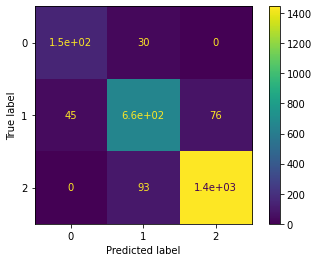

In [ ]:
plot_confusion_matrix(dtree_model, X_test, y_test)  
plt.show()

## Export

In [ ]:
#r = export_text(dtree_model, feature_names=features)
#print(r)

dump(svm_model, 'Tree_classifier.joblib') 

## Prediction

In [ ]:
# Create DataFrame from data to be predicted
prediction_df = pd.DataFrame([[1446923, 33, 31, 4962292, 84495, 2, 5, 1]], columns=features)
prediction_df

,Invested Amount,Successful Attacks,Failed Attacks,Business Value,Number of Employees,Employee Training,Known Vulnerabilities,External Advisor
0,1446923,33,31,4962292,84495,2,5,1


In [ ]:
predicted_risk = dtree_model.predict(prediction_df)[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: LOW


# Support Vector Machine (SVM) classifier

In [ ]:
from sklearn.svm import LinearSVC, SVC 

In [ ]:
# Data here is normalized
X_train, X_test, y_train, y_test = train_test_split(normalized_data[features].values, data["Risk"].values)

## Train

In [ ]:
# Linear
#svm_model = LinearSVC().fit(X_train, y_train)

svm_model = SVC(kernel='poly').fit(X_train, y_train)

## Evaluate

In [ ]:
accuracy = svm_model.score(X_test, y_test) 

print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 97.68%


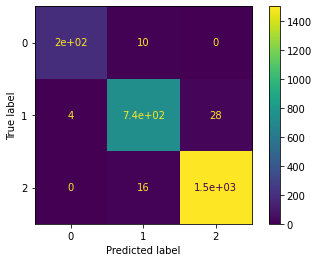

In [ ]:
plot_confusion_matrix(svm_model, X_test, y_test)  
plt.show()

## Export

In [ ]:
#dump(svm_model, 'SVM_classifier.joblib') 

## Prediction

In [ ]:
predicted_risk = svm_model.predict(normalized_prediction_df)[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: LOW


# K-nearest Neighbours Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# Data here is not normalized
X_train, X_test, y_train, y_test = train_test_split(normalized_data[features].values, data["Risk"].values)

## Train

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 10).fit(X_train, y_train) 

## Evaluate

In [ ]:
accuracy = knn.score(X_test, y_test) 
print('Accuracy: {0:.2%}'.format(accuracy))

Accuracy: 92.40%


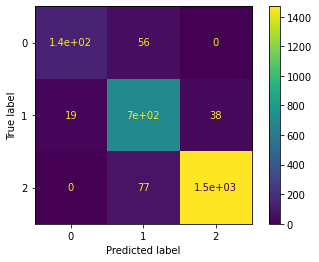

In [ ]:
plot_confusion_matrix(knn, X_test, y_test)  
plt.show()

## Export

In [ ]:
dump(knn, 'KNN_classifier.joblib') 

['KNN_classifier.joblib']

## Prediction

In [ ]:
predicted_risk = knn.predict(normalized_prediction_df)[0]
print("Predicted RISK is: " + prediction_result_mapping[predicted_risk])

Predicted RISK is: LOW
